# Libraries

Let's import all the libraries we need

In [31]:
import pandas as pd
import xgboost as xgb
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV

# Import data

We import the data simulated from the file 'data.h5'.

In [32]:
data = pd.read_hdf('data.h5')
data

,run,lumi,event,nL1Puppi,pi0_pt,pi1_pt,pi2_pt,pi0_eta,pi1_eta,pi2_eta,...,triplet_mindR,triplet_maxdVz,triplet_mindVz,is_train,is_valid,is_test,classS,classB,classF,class
0,1,3012,105,16,26.50,9.75,3.50,0.323242,-1.367188,-0.845703,...,1.253697,0.062500,-0.062500,True,False,False,0,0,1,0
1,1,11710,1870293,43,4.25,3.25,3.00,1.429688,0.767578,0.323242,...,1.371571,0.250000,-0.100098,True,False,False,0,1,0,0
2,1,8864,1415797,38,6.00,5.25,4.00,0.388672,-1.574219,-2.101562,...,0.838835,0.390625,-1.000000,True,False,False,0,1,0,0
3,1,3035,34,45,33.50,18.50,4.00,2.015625,1.789062,-0.335938,...,1.933244,0.101562,-0.050781,True,False,False,0,0,1,0
4,1,3252,519289,30,6.00,4.50,4.00,0.117920,2.304688,2.140625,...,0.920981,0.449219,0.199219,True,False,False,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64022,1,418,66696,47,13.75,4.75,3.75,-0.261719,-2.335938,-1.535156,...,1.042801,0.499512,-1.501465,False,False,True,0,1,0,0
64023,1,3870,618144,26,4.25,3.75,2.75,-1.015625,1.171875,1.582031,...,0.464844,-0.351562,-1.349609,False,False,True,0,1,0,0
64024,1,8066,1288288,32,8.50,5.50,4.00,-1.929688,2.085938,-1.167969,...,0.774591,0.148438,-0.453125,False,False,True,0,1,0,0
64025,1,562,89703,14,4.50,4.50,3.75,-0.841797,-0.841797,2.335938,...,0.000000,0.250000,0.000000,False,False,True,0,1,0,0


Each row in our dataset represents an event, while each column corresponds to a specific **feature**:

- The columns _run_, _lumi_, _event_, *is_valid*, *classS*, *classB*, and *classF* do not contain physics information and will not be used for model training.
- The columns *is_train* and *is_test* are used to split the data into a **training set** and a **testing set**. The training set is used to fit the model, while the testing set is reserved for evaluating its performance on unseen data.

In [33]:
train_data=data[data['is_train']]
test_data = data[data['is_test']]

# Train with every feature

> **X** is a matrix where each row represents an event and each column corresponds to a selected physics feature.  
> **y** is a vector containing the target class for each event: 0 if the event is not a W→3π decay, 1 if it is.


In [34]:
X_train = train_data.iloc[:, 3:63]
y_train = train_data['class']

X_test = test_data.iloc[:, 3:63]
y_test = test_data['class']

In [35]:
X_train

,nL1Puppi,pi0_pt,pi1_pt,pi2_pt,pi0_eta,pi1_eta,pi2_eta,pi0_phi,pi1_phi,pi2_phi,...,triplet_pt,triplet_charge,triplet_maxdEta,triplet_mindEta,triplet_maxdPhi,triplet_mindPhi,triplet_maxdR,triplet_mindR,triplet_maxdVz,triplet_mindVz
0,16,26.50,9.75,3.50,0.323242,-1.367188,-0.845703,2.445312,-1.507812,1.992188,...,23.594595,-1.0,1.690430,-0.521484,3.953125,-3.500000,2.878669,1.253697,0.062500,-0.062500
1,43,4.25,3.25,3.00,1.429688,0.767578,0.323242,0.392578,2.882812,1.203125,...,5.577529,1.0,1.106445,0.444336,1.679688,-2.490234,2.576753,1.371571,0.250000,-0.100098
2,38,6.00,5.25,4.00,0.388672,-1.574219,-2.101562,-0.218262,0.445312,1.097656,...,13.216339,-1.0,2.490234,0.527344,-0.652344,-1.315918,2.816542,0.838835,0.390625,-1.000000
3,45,33.50,18.50,4.00,2.015625,1.789062,-0.335938,-2.539062,-0.619141,2.679688,...,32.253708,-1.0,2.351562,0.226562,-1.919922,-5.218750,3.663607,1.933244,0.101562,-0.050781
4,30,6.00,4.50,4.00,0.117920,2.304688,2.140625,-0.257812,-1.148438,-2.054688,...,10.846830,1.0,0.164062,-2.186768,1.796875,0.890625,2.705568,0.920981,0.449219,0.199219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44814,55,20.50,18.00,12.25,-0.410156,-1.246094,-1.898438,2.625000,-0.798828,-0.300781,...,9.074035,-1.0,1.488281,0.652344,3.423828,-0.498047,3.282557,0.820733,1.402344,0.351562
44815,31,4.00,3.50,3.00,2.335938,0.720703,1.046875,2.765625,0.925781,-1.851562,...,2.811338,-3.0,1.615234,-0.326172,4.617188,1.839844,2.796431,2.106473,0.343750,-0.046875
44816,33,8.00,5.50,4.25,-2.187500,-1.898438,1.292969,-3.101562,0.056763,0.270508,...,1.951677,-1.0,-0.289062,-3.480469,-0.213745,-3.372070,4.537428,3.138201,0.093750,-0.546875
44817,27,4.50,4.25,3.75,0.785156,0.955078,0.252930,0.065430,-1.789062,-1.996094,...,7.547030,-3.0,0.702148,-0.169922,2.061523,0.207031,2.129118,0.732034,0.201172,-0.351562


We define our model using an *XGBClassifier* object and train it with the *fit* method.  
We provide three key parameters to *xgboost.XGBClassifier()*:
- *n_estimators*: number of trees in the model
- *max_depth*: maximum depth of each tree
- *learning_rate*: controls how much each tree contributes to the final prediction

The *fit* method takes two arguments: the feature matrix *X* and the target vector *y* (both are pandas dataframes in this case).  
For further details, see the [xgboost documentation](https://xgboost.readthedocs.io/en/latest/).

In [36]:
clf = xgb.XGBClassifier(n_estimators=20, max_depth=3, learning_rate=1.0).fit(X_train, y_train)

We use the trained classifier to predict the class labels for the test set features (**X_test**).  
The predicted labels (**y_pred**) represent the model's classification for each event in the test set.  
To ensure compatibility with subsequent calculations, we convert the true test labels (**y_test**) to a NumPy array.  
This allows for efficient comparison and evaluation of the model's performance.

The `.predict` method of an `XGBClassifier` returns a vector of 0s and 1s, where each value corresponds to the predicted class for an event.  
These values have the same meaning as those in **y_test**:  
- **0** indicates the event is not predicted to be a W→3π decay  
- **1** otherwise


In [37]:
y_pred = clf.predict(X_test)
y_test = y_test.to_numpy()

## Test the model

We now test the performance of the model on the test set.
Initially, with the logic xor operator, we can check how many times `y_pred` differs from `y_test`: that is, `control` is an array containing 1 when the prediction is wrong.

In [38]:
control = (y_pred ^ y_test)
print(f'Ratio of wrong predictions: {sum(control)/len(control):.2f}')

Ratio of wrong predictions: 0.02


### False negatives

Now we check how many false negatives the model predicts: that is how many "true signals" are not considered as such by the model

In [39]:
signal_indexes = np.where(y_test==1)
control = (y_pred[signal_indexes] ^ y_test[signal_indexes])
print(f'Ratio of false negatives: {sum(control)/len(control):.2f}')

Ratio of false negatives: 0.08


### False positives

We also check the ratio of false positives (events that get predicted as sinals but in reality are not)

In [40]:
signal_indexes = np.where(y_pred==1)
control = y_pred[signal_indexes] ^ y_test[signal_indexes]
print(f'Ratio of false positives: {sum(control)/len(control):.2f}')

Ratio of false positives: 0.06


### ROC curve

A **ROC curve** (Receiver Operating Characteristic curve) is a graphical representation used to evaluate the performance of a binary classification model. It plots the **True Positive Rate** (TPR, also known as sensitivity or recall) against the **False Positive Rate** (FPR, which is 1 - specificity) at various threshold settings.

- **True Positive Rate (TPR):** The proportion of actual positives correctly identified by the model.
- **False Positive Rate (FPR):** The proportion of actual negatives incorrectly identified as positives.

The ROC curve illustrates how well the model distinguishes between the two classes as the decision threshold changes. A model with perfect discrimination will have a curve that passes through the top-left corner (TPR=1, FPR=0). The **Area Under the Curve (AUC)** quantifies the overall ability of the model to discriminate between positive and negative classes; an AUC of 1.0 indicates perfect classification, while an AUC of 0.5 suggests no discriminative power (equivalent to random guessing).

ROC curves are especially useful for comparing different models and understanding the trade-off between sensitivity and specificity.

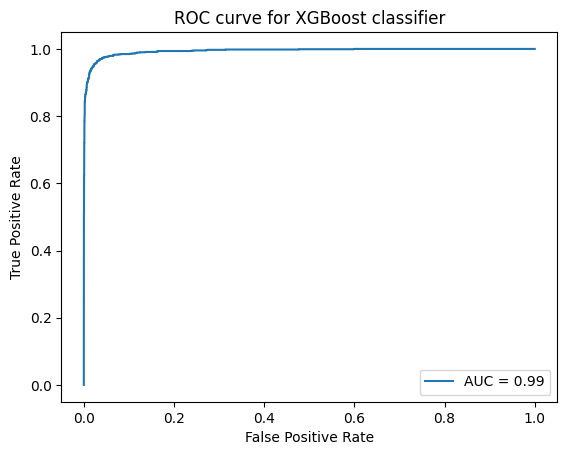

In [41]:
y_prob = clf.predict_proba(X_test)[:, 1]
fpr_all, tpr_all, _ = metrics.roc_curve(y_test, y_prob)
plt.plot(fpr_all, tpr_all)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for XGBoost classifier')
plt.legend(['AUC = {:.2f}'.format(metrics.roc_auc_score(y_test, y_prob))])
plt.show()

# Rate Importance

XGBoost evaluates feature importance based on how often and how effectively each feature is used to split the data across all trees in the model. It calculates metrics such as:

- **Gain:** Measures the improvement in accuracy brought by a feature to the branches it splits.
- **Weight:** Counts the number of times a feature is used to split the data.
- **Cover:** Reflects the number of samples affected by splits on a feature.

These metrics are aggregated during training, allowing XGBoost to rank features by their contribution to the model’s predictive power. This ranking helps identify which features are most influential in distinguishing between signal and non-signal events.  
We will now choose the ten most important features, train a new model that only uses them and compare its performance with the old model.  

Notice that a more in-depth feature analysis can be conducted; for instance, certain features may be excluded due to physics-based considerations.

In [42]:
# Obtain feature importances
feature_importances = clf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for clearer visualization
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

importance_df.T

,3,37,49,24,59,50,1,47,51,2,...,42,41,29,28,40,39,36,32,34,35
feature,pi2_pt,m_01,triplet_mass,pi2_iso,triplet_mindVz,triplet_pt,pi0_pt,dVz_02,triplet_charge,pi1_pt,...,m2_12,m2_02,dPhi_02,dPhi_01,m2_01,m_12,dR2_12,dR_02,dR2_01,dR2_02
importance,0.532292,0.100773,0.065096,0.043319,0.02657,0.023183,0.020771,0.020342,0.017386,0.017019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# Select the ten most important features
importance_df = importance_df.sort_values(by='importance', ascending=False)
most_important=[]
for i in range(10):
    most_important.append(importance_df.iloc[i].name)
most_important = np.array(most_important)

In [44]:
print(most_important)

[ 3 37 49 24 59 50  1 47 51  2]


# Train with most important features

In [45]:
X_train = train_data.iloc[:, most_important+3]
y_train = train_data['class']

X_test = test_data.iloc[:, most_important+3]
y_test = test_data['class']

In [46]:
clf = xgb.XGBClassifier(n_estimators=20, max_depth=3, learning_rate=1.0).fit(X_train, y_train)

In [47]:
y_pred = clf.predict(X_test)
y_test = y_test.to_numpy()

## Test the new model

In [48]:
control = (y_pred ^ y_test)
print(f'Ratio of wrong predictions: {sum(control)/len(control):.2f}')
# false negatives
signal_indexes = np.where(y_test==1)
control = (y_pred[signal_indexes] ^ y_test[signal_indexes])
print(f'Ratio of false negatives: {sum(control)/len(control):.2f}')
# false positives
signal_indexes = np.where(y_pred==1)
control = y_pred[signal_indexes] ^ y_test[signal_indexes]
print(f'Ratio of false positives: {sum(control)/len(control):.2f}')


Ratio of wrong predictions: 0.02
Ratio of false negatives: 0.08
Ratio of false positives: 0.06


### ROC curve

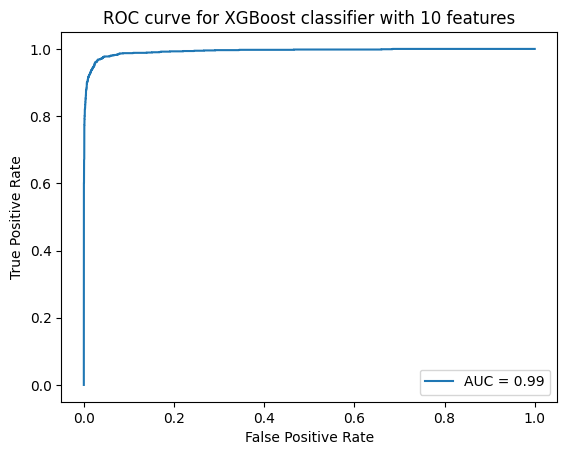

In [49]:
y_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for XGBoost classifier with 10 features')
plt.legend(['AUC = {:.2f}'.format(metrics.roc_auc_score(y_test, y_prob))])
plt.show()

# Train with least important features

For demonstative porpuses, we now train a third model using 5 of the least important features

In [50]:
importance_df = importance_df.sort_values(by='importance', ascending=True)
most_important=[]
for i in range(5):
    most_important.append(importance_df.iloc[i].name)
most_important = np.array(most_important)
print(most_important)

[16 17 42 41 15]


In [51]:
X_train = train_data.iloc[:, most_important+3]
y_train = train_data['class']

X_test = test_data.iloc[:, most_important+3]
y_test = test_data['class']

In [52]:
clf = xgb.XGBClassifier(n_estimators=20, max_depth=3, learning_rate=1.0).fit(X_train, y_train)

In [53]:
y_pred = clf.predict(X_test)
y_test = y_test.to_numpy()

## Test the model

In [54]:
control = (y_pred ^ y_test)
print(f'Ratio of wrong predictions: {sum(control)/len(control):.2f}')
# false negatives
signal_indexes = np.where(y_test==1)
control = (y_pred[signal_indexes] ^ y_test[signal_indexes])
print(f'Ratio of false negatives: {sum(control)/len(control):.2f}')
# false positives
signal_indexes = np.where(y_pred==1)
control = y_pred[signal_indexes] ^ y_test[signal_indexes]
print(f'Ratio of false positives: {sum(control)/len(control):.2f}')


Ratio of wrong predictions: 0.11
Ratio of false negatives: 0.35
Ratio of false positives: 0.32


### ROC curve

We now compare all three ROC curves. We can see how there is basically no diffecerence in accuracy between the model that uses every single feature and the one that only uses the 10 most important. We thus do not need to use them all, as more features means more computational cost.

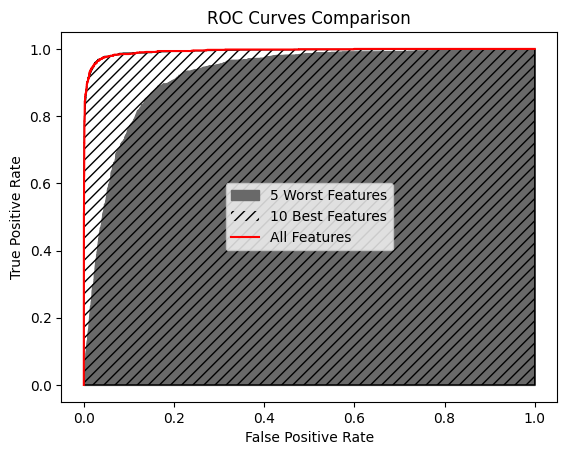

In [55]:
y_prob = clf.predict_proba(X_test)[:, 1]
fpr2, tpr2, _ = metrics.roc_curve(y_test, y_prob)
plt.clf()
plt.fill_between(fpr2, 0, tpr2, label='5 Worst Features', color='dimgray')
plt.fill_between(fpr, 0, tpr, label='10 Best Features', hatch='///', facecolor='None')
plt.plot(fpr_all, tpr_all, label='All Features', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.savefig('rocs.png')

We print their area unde curve:

In [56]:
print(f'Best Features: {metrics.auc(fpr, tpr)}\nWorst Features: {metrics.auc(fpr2, tpr2)}')
print(f'All Features: {metrics.auc(fpr_all, tpr_all)}')

Best Features: 0.9934636076129456
Worst Features: 0.9240969874752343
All Features: 0.9940133253899455


In [57]:
print(y_prob)

[0.03957142 0.00024628 0.00062399 ... 0.01796478 0.10222328 0.01862697]


# Hyperparameters optimization

We now lock ourselves into the hyperparameter optimization process, seeking the ideal hyperparameters for the model. That is we look for the combination of hyperparameters (`max_depth`, `n_estimators`, `learning_rate`, etc.) which maximize the accuracy.

The parameters for the `XGBClassifier` class control how the model is trained and how it learns from the data:

- **n_estimators**: The number of trees (boosting rounds) to build. More trees can improve accuracy but may increase computation time and risk overfitting.
- **max_depth**: The maximum depth of each tree. Deeper trees can capture more complex patterns but may also overfit.
- **learning_rate**: How much each tree contributes to the overall prediction. Lower values make learning slower but can improve generalization.
- **grow_policy**: The strategy for growing trees. `'depthwise'` grows trees level by level, while `'lossguide'` splits nodes based on the loss reduction, which can be more efficient for large datasets.
- **subsample**: The fraction of the training data used to grow each tree. Values less than 1.0 help prevent overfitting by introducing randomness.
- **colsample_bytree**: The fraction of features (columns) used to grow each tree. Like subsample, this adds randomness and can improve generalization.

In [58]:
# we work only with the 10 most important features
importance_df = importance_df.sort_values(by='importance', ascending=False)
most_important=[]
for i in range(10):
    most_important.append(importance_df.iloc[i].name)
most_important = np.array(most_important)
print(most_important)

[ 3 37 49 24 59 50  1 47 51  2]


In [59]:
X_train = train_data.iloc[:, most_important+3]
y_train = train_data['class']

X_test = test_data.iloc[:, most_important+3]
y_test = test_data['class']

We manually perform a grid search on the parameters `n_estimators` and `max_depth`: we train a model for every combination of these parameters from 1 to 50to compare the accuracy of each model

In [60]:
performances=[]
xs=[]
ys=[]
fprs=[]
tprs=[]
for n_estimators in range(1, 50):
    for max_depth in range(1, 10):
        clf = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=1.0).fit(X_train, y_train)
        y_prob = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = metrics.roc_curve(y_test, y_prob)
        fprs.append(fpr)
        tprs.append(tpr)
        performance=metrics.auc(fpr, tpr)
        performances.append(performance)
        xs.append(n_estimators)
        ys.append(max_depth)

Text(0, 0.5, 'tpr')

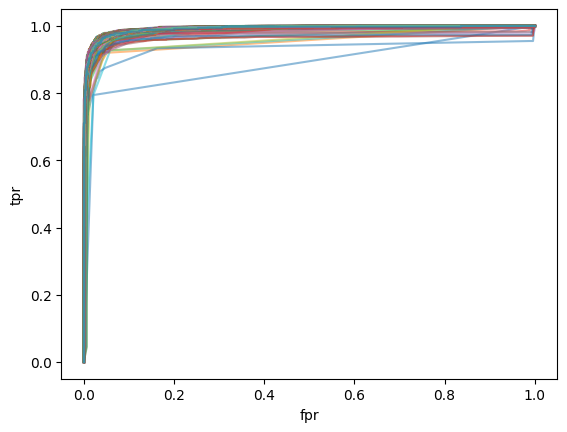

In [61]:
# we plot all the ROC curves
for i in range(len(fprs)):
    plt.plot(fprs[i], tprs[i], alpha=0.5)

plt.xlabel('fpr')
plt.ylabel('tpr')


[Text(0, 0, '1'),
 Text(0, 1, '2'),
 Text(0, 2, '3'),
 Text(0, 3, '4'),
 Text(0, 4, '5'),
 Text(0, 5, '6'),
 Text(0, 6, '7'),
 Text(0, 7, '8'),
 Text(0, 8, '9')]

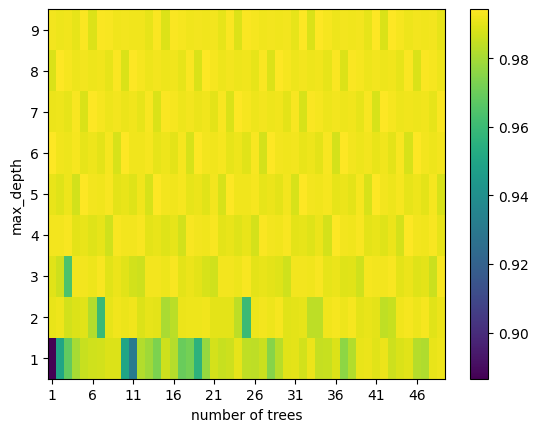

In [62]:
# Reshape performances to (max_depth, n_estimators)
perf_matrix = np.array(performances).reshape(9, 49)  # 9 max_depths, 49 n_estimators

fig, ax = plt.subplots()
im = ax.imshow(perf_matrix, aspect='auto', origin='lower', cmap='viridis')
fig.colorbar(im)
ax.set_xlabel('number of trees')
ax.set_ylabel('max_depth')
ax.set_xticks(np.arange(0, 49, 5))
ax.set_yticks(np.arange(0, 9, 1))
ax.set_xticklabels(np.arange(1, 50, 5))
ax.set_yticklabels(np.arange(1, 10, 1))

We observe that the accuracy rapidly approaches an asymptote: as with feature selection, it is unnecessary to allocate excessive resources to increasingly complex models.

## Scikit-learn GridSearchCV

`GridSearchCV` is a tool from scikit-learn that automates the process of hyperparameter tuning for machine learning models. It systematically tests all possible combinations of specified hyperparameter values to find the set that yields the best model performance, typically measured by cross-validation accuracy.

### How It Works

1. **Parameter Grid**: You define a dictionary of hyperparameters and their possible values.
2. **Model Training**: For each combination of hyperparameters, the model is trained and evaluated using cross-validation.
3. **Performance Evaluation**: The average score (e.g., accuracy, AUC) across the cross-validation folds is computed for each combination.
4. **Best Model Selection**: The combination with the highest score is selected, and the model is refit on the entire training set using these optimal parameters.

**Cross-validation** is a statistical technique used to evaluate the performance and generalizability of a machine learning model. Instead of training and testing the model on a single split of the data, cross-validation divides the dataset into multiple subsets (called "folds"). The model is trained on some folds and tested on the remaining fold, repeating this process so that each fold serves as the test set once. The results are then averaged to provide a more robust estimate of model performance.


We use `GridSearchCV` to optimize the hyperparameters of the `XGBClassifier`. Specifically:

- We define a grid of possible values for parameters like `n_estimators`, `max_depth`, `learning_rate`, `grow_policy`, `subsample`, and `colsample_bytree`.
- We create a `GridSearchCV` object with the classifier and the parameter grid.
- We fit the grid search to our training data (`X_train`, `y_train`), which automatically tests all combinations and performs cross-validation.
- After fitting, we extract the best hyperparameters and the best model, which we then use to predict and evaluate performance on the test set.


In [ ]:
# We first define the parameter grid
parameters = {
    'n_estimators': range(1, 20),
    'max_depth': range(1, 7),
    'learning_rate': np.linspace(0.01, 1, 10),
    'grow_policy': ['depthwise', 'lossguide'],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [ ]:
# We create the GridSearchCV object
clf = GridSearchCV(xgb.XGBClassifier(), parameters)

In [75]:
clf.fit(X_train, y_train) #this might take a while ...

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.8, 1.0], 'grow_policy': ['depthwise', 'lossguide'], 'learning_rate': array([0.01, ..., 0.89, 1. ]), 'max_depth': range(1, 7), ...}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [ ]:
print("Best hyperparameters:", clf.best_params_)
print("Best cross-validation score:", clf.best_score_)

Best hyperparameters: {'colsample_bytree': 1.0, 'grow_policy': 'depthwise', 'learning_rate': np.float64(0.45), 'max_depth': 5, 'n_estimators': 19, 'subsample': 1.0}
Best cross-validation score: 0.9787813532384588


We finally extrapolate and save our model as a `.json` file

In [77]:
model = clf.best_estimator_ # Extract the best model
model.save_model('best_model.json')

## Test the "best" model

In [78]:
y_prob = model.predict_proba(X_test)[:, 1] # Extract probabilities for the positive class

In [79]:
control = (y_pred ^ y_test)
print(f'Ratio of wrong predictions: {sum(control)/len(control):.2f}')
# false negatives
signal_indexes = np.where(y_test==1)
control = (y_pred[signal_indexes] ^ y_test[signal_indexes])
print(f'Ratio of false negatives: {sum(control)/len(control):.2f}')
# false positives
signal_indexes = np.where(y_pred==1)
control = y_pred[signal_indexes] ^ y_test[signal_indexes]
print(f'Ratio of false positives: {sum(control)/len(control):.2f}')


Ratio of wrong predictions: 0.03
Ratio of false negatives: 0.09
Ratio of false positives: 0.07


### ROC curve

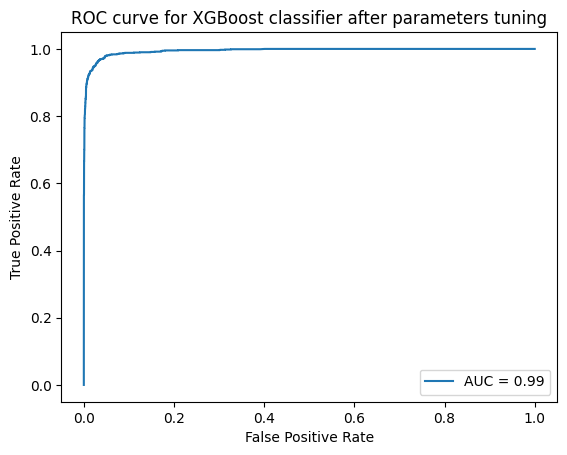

In [80]:
y_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for XGBoost classifier after parameters tuning')
plt.legend(['AUC = {:.2f}'.format(metrics.roc_auc_score(y_test, y_prob))])
plt.show()